## DeepSynergy

Author: Kristina Preuer

This Keras script shows how DeepSynergy was evaluated in one cross validation run (executed 5 times - looping over test folds). In this examples fold 0 is used for testing. The script uses 60% of the data  for training (folds 2, 3, 4) and 20% for validation (fold 1). The parameters are loaded with a separate text file (hyperparameters). Validation loss was used to determine the early stopping parameter. After hyperparameter selection the training and validation data was combined (80% = folds 1, 2, 3, 4) and the remaining 20% (fold 0) of the data were used for testing.

The original work was done accordingly with binet (https://github.com/bioinf-jku/binet/tree/master/binet). 

In [1]:
import sys
from google.colab import drive
drive.mount('/content/drive')
path = "/content/drive/MyDrive/Colab_Notebooks/DeepSynergy"
import os
os.chdir(path)

Mounted at /content/drive


In [2]:
#!pip install tensorflow
#!pip install keras

In [3]:
!nvidia-smi

Fri Jun 24 00:14:00 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
import os, sys

import pandas as pd
import numpy as np
import pickle
import gzip

import matplotlib.pyplot as plt

os.environ["CUDA_VISIBLE_DEVICES"]="0" #specify GPU 
import keras as K
import tensorflow as tf
from keras import backend
from tensorflow.compat.v1.keras.backend import set_session
from keras import Sequential
from keras.layers import Dense, Dropout
#from tensorflow.python.keras import layers, models


In [5]:
tf.test.gpu_device_name()

'/device:GPU:0'

#### Define smoothing functions for early stopping parameter

In [6]:
def moving_average(a, n=3):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

#### Define parameters for this cross-validation run

In [7]:
hyperparameter_file = 'hyperparameters' # textfile which contains the hyperparameters of the model
data_file = 'dataset/data_15_emb_c33_testfold0.p' # pickle file which contains the data (produced with normalize.ipynb)

#### Load parameters defining the model

In [8]:
#exec(open(hyperparameter_file).read()) 
layers_setting = [8182,4096,1] 
epochs = 1000
act_func = tf.nn.relu 
dropout = 0.5 
input_dropout = 0.2
eta = 1e-4
norm = 'tanh' 

#### Load data 
tr = 60% of data for training during hyperparameter selection <br>
val = 20% of data for validation during hyperparameter selection

train = tr + val = 80% of data for training during final testing <br>
test = remaining left out 20% of data for unbiased testing 

splitting and normalization was done with normalize.ipynb

In [9]:
file = gzip.open(data_file, 'rb')
X_tr, X_val, X_train, X_test, y_tr, y_val, y_train, y_test = pickle.load(file)
file.close()

In [10]:
X_val.shape

(1200, 53)

#### run set  

In [11]:
config = tf.compat.v1.ConfigProto(
         allow_soft_placement=True,
         gpu_options = tf.compat.v1.GPUOptions(allow_growth=True))
set_session(tf.compat.v1.Session(config=config))

In [12]:
model = Sequential()
for i in range(len(layers_setting)):
    if i==0:
        model.add(Dense(layers_setting[i], input_shape=(X_tr.shape[1],), activation=act_func, 
                        kernel_initializer='he_normal'))
        model.add(Dropout(float(input_dropout)))
    elif i==len(layers_setting)-1:
        model.add(Dense(layers_setting[i], activation='linear', kernel_initializer="he_normal"))
    else:
        model.add(Dense(layers_setting[i], activation=act_func, kernel_initializer="he_normal"))
        model.add(Dropout(float(dropout)))
model.compile(loss='mean_squared_error', optimizer=K.optimizers.gradient_descent_v2.SGD(learning_rate=float(eta), momentum=0.5, decay=0.001))

#### run model for hyperparameter selection

In [13]:
hist = model.fit(X_tr, y_tr, epochs=int(epochs), shuffle=True, batch_size=64, validation_data=(X_val, y_val))  
val_loss = hist.history['val_loss'] 

model.reset_states()

Epoch 1/1000
57/57 [==============================] - 3s 8ms/step - loss: 513.7976 - val_loss: 634.0522
Epoch 2/1000
57/57 [==============================] - 0s 6ms/step - loss: 489.7577 - val_loss: 469.8297
Epoch 3/1000
57/57 [==============================] - 0s 6ms/step - loss: 467.4089 - val_loss: 465.5399
Epoch 4/1000
57/57 [==============================] - 0s 6ms/step - loss: 462.0704 - val_loss: 457.9982
Epoch 5/1000
57/57 [==============================] - 0s 6ms/step - loss: 449.5974 - val_loss: 448.7111
Epoch 6/1000
57/57 [==============================] - 0s 6ms/step - loss: 434.6508 - val_loss: 451.5812
Epoch 7/1000
57/57 [==============================] - 0s 6ms/step - loss: 430.9343 - val_loss: 431.6251
Epoch 8/1000
57/57 [==============================] - 0s 7ms/step - loss: 420.9234 - val_loss: 442.7079
Epoch 9/1000
57/57 [==============================] - 0s 6ms/step - loss: 414.0332 - val_loss: 442.1487
Epoch 10/1000
57/57 [==============================] - 0s 6ms/st

#### smooth validation loss for early stopping parameter determination

In [18]:
average_over = 15
mov_av = moving_average(np.array(val_loss), average_over)   
smooth_val_loss = np.pad(mov_av, int(average_over/2), mode='edge')
epo = np.argmin(smooth_val_loss)   # callback

In [15]:
epo

990

#### determine model performance for methods comparison 

In [16]:
hist = model.fit(X_train, y_train, epochs=epo, shuffle=True, batch_size=64, validation_data=(X_test, y_test))
test_loss = hist.history['val_loss']
model.save('my_model_15_emb_c33.h5')

Epoch 1/990
76/76 [==============================] - 1s 7ms/step - loss: 190.3173 - val_loss: 313.2562
Epoch 2/990
76/76 [==============================] - 0s 6ms/step - loss: 185.7085 - val_loss: 312.0625
Epoch 3/990
76/76 [==============================] - 0s 6ms/step - loss: 190.4039 - val_loss: 310.6079
Epoch 4/990
76/76 [==============================] - 0s 6ms/step - loss: 187.9960 - val_loss: 309.0050
Epoch 5/990
76/76 [==============================] - 0s 6ms/step - loss: 183.2385 - val_loss: 307.9654
Epoch 6/990
76/76 [==============================] - 0s 6ms/step - loss: 186.5259 - val_loss: 307.5292
Epoch 7/990
76/76 [==============================] - 0s 6ms/step - loss: 184.8938 - val_loss: 306.0210
Epoch 8/990
76/76 [==============================] - 0s 6ms/step - loss: 186.0890 - val_loss: 306.3263
Epoch 9/990
76/76 [==============================] - 0s 6ms/step - loss: 180.3765 - val_loss: 305.5176
Epoch 10/990
76/76 [==============================] - 0s 6ms/step - loss:

#### plot performance 

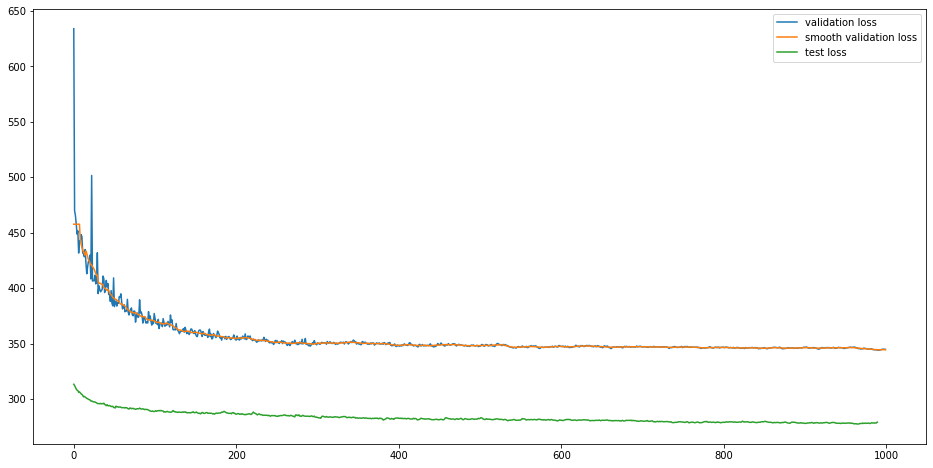

In [17]:
fig, ax = plt.subplots(figsize=(16,8))
ax.plot(val_loss, label='validation loss')
ax.plot(smooth_val_loss, label='smooth validation loss')
ax.plot(test_loss, label='test loss')  
ax.legend() 
plt.show()